In [1]:
# // ===============================
# // AUTHOR     : Ali Raza
# // CREATE DATE     : Dec 22, 2019
# // PURPOSE     : main function. a wrapper of charge perdiction system for testing and evaluation 
# // SPECIAL NOTES: Uses charge_prediction_system that uses data_handling.py and model.py
# // ===============================
# // Change History: 1.0: initial code: wrote and tested.
# // Change History: 2.0: updated code: added mini batches
# //
# //==================================
__author__ = "Ali Raza"
__copyright__ = "Copyright 2019"
__credits__ = []
__license__ = ""
__version__ = "2.0"
__maintainer__ = "ali raza"
__email__ = "razaa@oregonstate.edu"
__status__ = "done"

from data_handling import *
from model import *
from charge_prediction_system import *
from torch_geometric.data import Data, DataLoader
import os
import numpy as np
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import math
from random import shuffle
import copy
import pandas as pd
import seaborn as sns
import csv

print("----------------------------------------------")
print(">>> loading parameters")

# GRAPHS_LOCATION = "../build_graphs/graphs"
GRAPHS_LOCATION = "input"
ONE_HOT_ENCODING_CSV = "../atom_to_int.csv" 
TRAINING_SET_CUT = 70 # percentage
VALIDATION_SET_CUT = 10 # percentage 
#remaining is test set
MAX_EPOCHS = 150
BATCH_SIZE = 32
MAX_ITERATIONS = 1

GNN_LAYERS = 4
EMBEDDING_SIZE = 10
HIDDEN_FEATURES_SIZE = 30

# crit = torch.nn.MSELoss()
crit = torch.nn.L1Loss()

# systems = ['vanilla', 'soft_con', 'mean_cor', 'gaussian_cor']
systems = ['mean_cor', 'gaussian_cor']
FLAG_SAVE_EMBEDDING = False
hfont= {'fontname':'DejaVu Sans'}
fontsize_label_legend = 24

if not(os.path.exists("results/")):
    os.mkdir('results/')
if not(os.path.exists('results/graphs')):
    os.mkdir('results/graphs')
if not(os.path.exists('results/embedding')):
    os.mkdir('results/embedding')
    
    
print("...done")
print("----------------------------------------------")

----------------------------------------------
>>> loading parameters
...done
----------------------------------------------


In [2]:


print("----------------------------------------------")
print(">>> reading graphs and generating data_list")
data_list = data_handling(GRAPHS_LOCATION, READ_LABELS = True)
print("...done")
print("----------------------------------------------")
print()

# dividing data into testing and training
NUM_NODE_FEATURES = data_list[0]['x'].shape[1]

device = torch.device('cuda')
# crit = torch.nn.MSELoss()
crit = torch.nn.L1Loss()




print(">>> reading one-hot encoding")
with open(ONE_HOT_ENCODING_CSV) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    element_types = []
    one_hot_encoding = []
    next(readCSV)
    for row in readCSV:
        element_types.append(row[0])
        one_hot_encoding.append(int(row[1]))

#     print(element_types)
#     print(one_hot_encoding)
    # sorting them
    indices_sorted_elements = np.argsort(one_hot_encoding)
    element_types = np.array(element_types)[indices_sorted_elements]
    one_hot_encoding = np.array(one_hot_encoding)[indices_sorted_elements]
#     print(element_types)
#     print(one_hot_encoding)
print("...done")
print("-----------------------------------------------------------------------------------------")

----------------------------------------------
>>> reading graphs and generating data_list
total crystals:  2266
...done
----------------------------------------------

>>> reading one-hot encoding
...done
-----------------------------------------------------------------------------------------


In [3]:

print("----------------------------------------------")
print(">>> shuffling data for different training, validation, and testing sets each run")
data_size = len(data_list)
cut_training = int(data_size * (TRAINING_SET_CUT/100) )
cut_validation = int(data_size * (TRAINING_SET_CUT + VALIDATION_SET_CUT)/100)
# iteration = 0
data_list_shuffled = copy.deepcopy(data_list)        
# making sure training_dataset has all the elements after shuffling 
unique_flag = False
while unique_flag == False:
    
    unique_flag = True
    shuffle(data_list_shuffled) 
    train_dataset = data_list_shuffled[:cut_training]
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
    for data in train_loader:
        data = data.to(device)
        label = data.y.to(device)
        features = data.x.to(device)
        elements_number = len(features[0])
        for element_index in range(elements_number):
            indices = (features[:, element_index] == 1)
            if len( (label[indices]))  == 0 :# number of atoms in datasets
                print('{} is not in training set, trying again...'.format(element_types[element_index]),  end="\r", flush=True)
                unique_flag = False
                break

print('shuffling datasets is done.............!!')

# ------------------------


valid_dataset = data_list_shuffled[cut_training:cut_validation]
test_dataset = data_list_shuffled[cut_validation:]
train_data_size = len(train_dataset)
valid_data_size = len(valid_dataset)
test_data_size = len(test_dataset)

 
            

print("training crystals: {}".format(train_data_size ))
print("validation crystals: {}".format(valid_data_size))
print("testing crystals: {}".format(test_data_size))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


----------------------------------------------
>>> shuffling data for different training, validation, and testing sets each run
shuffling datasets is done.............!!.
training crystals: 1586
validation crystals: 226
testing crystals: 454


total MOFs: 2266
total nodes: 334103


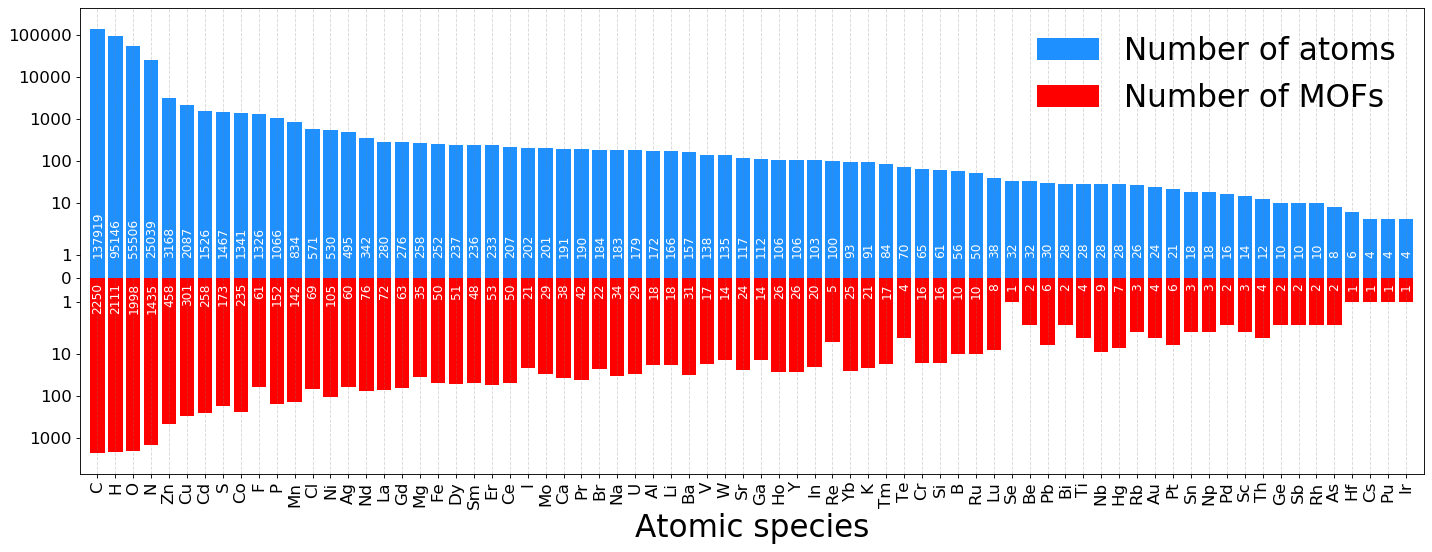

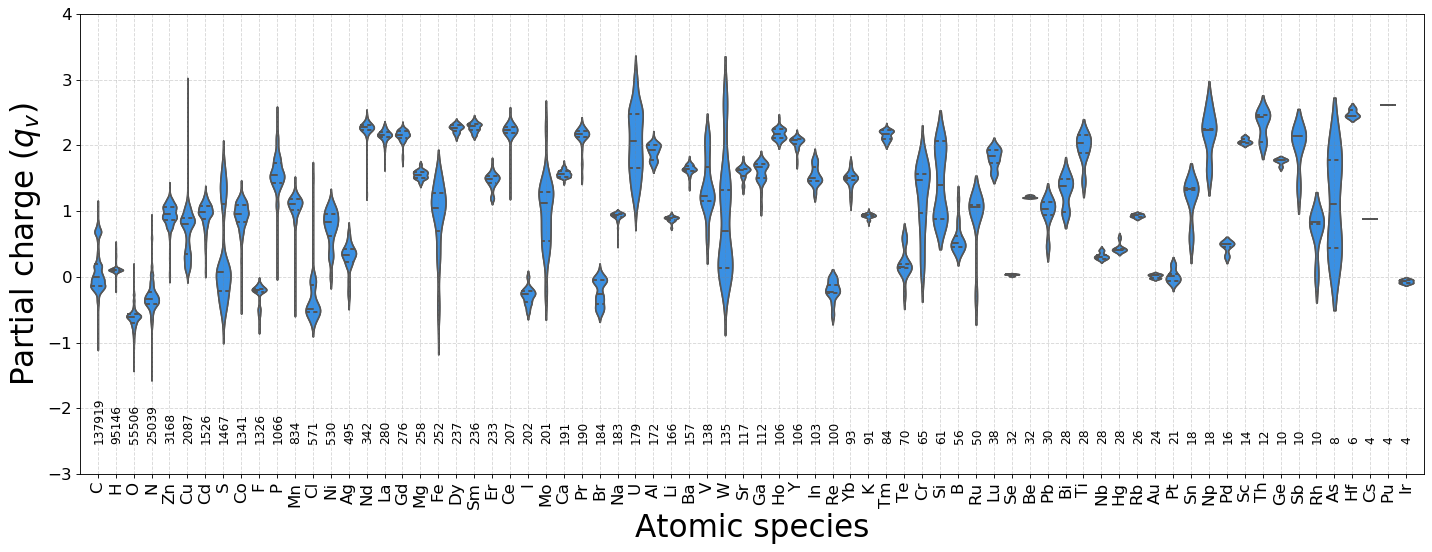

In [4]:
#-----------------------------------------------
# for generating graphs related to the data



dataa = data_list
# dataa = test_dataset
# dataa = train_dataset
loader = DataLoader(dataa, batch_size=len(dataa))
print("total MOFs: {}".format(len(dataa) ))



for data in loader:
        data = data.to(device)
        label = data.y.to(device)
        features = data.x.to(device)
        print("total nodes: {}".format(len(label)))
        
        elements_number = len(features[0])
        total_instances_all = np.zeros(elements_number)
        total_instances_mof_all = np.zeros(elements_number)
#         mean_element_all = np.zeros(elements_number)
#         min_element_all = np.zeros(elements_number)
#         max_element_all = np.zeros(elements_number)
        
        for element_index in range(elements_number):
            indices = (features[:, element_index] == 1)
            label_element = label[indices].cpu().numpy()
            total_instances_all[element_index] = len( (label[indices])) # number of atoms in datasets
            total_instances_mof_all[element_index] = len(set(data.batch[indices].cpu().numpy())) # number of mofs containing that element
        
#             mean_element_all[element_index] = np.mean(label_element)
#             min_element_all[element_index] = min(label_element)
#             max_element_all[element_index] = max(label_element)
        
        # indices of sorted element
        
        indices_sorted_elements = np.argsort(total_instances_all)
        indices_sorted_elements=np.flipud(indices_sorted_elements)
#%-----------------------------------------------------------------------        
        
        
        fig = plt.figure(figsize=(18, 7), dpi= 80) # Create matplotlib figure
        ax = fig.add_subplot(111) # Create matplotlib axes
        ax.bar(np.arange(elements_number), total_instances_all[indices_sorted_elements], label='Number of atoms', color= 'dodgerblue')
        ax.bar(np.arange(elements_number), -1*(total_instances_mof_all[indices_sorted_elements]), label='Number of MOFs', color='red')        
        plt.tick_params(axis='both', which='major', labelsize=16)
        # Formatting x labels
        plt.xlabel("Atomic species", fontsize=28, **hfont)
        ax.set_xticks(np.arange(elements_number))
        element_types2 = np.array(element_types)[indices_sorted_elements]
        ax.set_xticklabels(element_types2,  size=15, **hfont)
        plt.xticks(rotation=90)
        
        ax.set_yscale('symlog')
        # Use absolute value for y-ticks
        ticks =  ax.get_yticks()
        ax.set_yticklabels([int(abs(tick)) for tick in ticks])
        for index, data in enumerate((total_instances_all[indices_sorted_elements].astype(int))):
            plt.text(x=index+0.03, y= 1, s=f"{data}", fontdict=dict(fontsize=11), rotation='vertical', color='white', ha='center')
        for index, data in enumerate((total_instances_mof_all[indices_sorted_elements].astype(int))):
            plt.text(x=index+0.03, y= -0.2, s=f"{data}", fontdict=dict(fontsize=11), rotation='vertical', color='white', va='top', ha='center')
#         plt.legend(frameon=False, prop={"family":"Times New Roman", 'size': 28})
        plt.legend(frameon=False, prop={"family":"DejaVu Sans", 'size': 28})
        plt.xlim([-1,74])
        plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.tight_layout()
        plt.savefig('results/graphs/dataset_element_distribution.png', format='png', dpi=300, bbox_inches="tight")
        plt.show()
#%-----------------------------------------------------------------------        
 
        
        #-- sorted
        
#         plt.figure(figsize=(18,7), dpi= 80)
        fig = plt.figure(figsize=(18, 7), dpi= 80) # Create matplotlib figure
        ax = fig.add_subplot(111) # Create matplotlib axes
        element_types_labels = np.zeros(len(label))
        
        for element_index in range(elements_number):
                indices = (features[:, indices_sorted_elements[element_index] ] == 1)
                element_types_labels[indices.cpu().numpy()] = element_index
        
#         sns.violinplot(x=element_types_labels, y=label.cpu().numpy(), scale='width', inner='quartile',palette="GnBu_d")
        sns.violinplot(x=element_types_labels, y=label.cpu().numpy(), scale='width', inner='quartile',palette=sns.light_palette((210, 90, 60), input="husl"))
        sns.violinplot(x=element_types_labels, y=label.cpu().numpy(), scale='width', inner='quartile',color="dodgerblue", alpha=0.7)
        # Decoration
        plt.xlabel("Atomic species", fontsize = 28, **hfont)
        plt.ylabel('Partial charge ' + r'$(q_v)$', fontsize = 28, **hfont)
        plt.xticks(np.arange(elements_number), element_types2, rotation='vertical', size=15, **hfont)
        for index, data in enumerate((total_instances_all[indices_sorted_elements].astype(int))):
            plt.text(x=index-0.3, y= -2.5, s=f"{data}", fontdict=dict(fontsize=11), rotation='vertical', color='black')
        plt.ylim((-3,4))
        plt.xlim((-1,74))
        plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
        plt.gca().yaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.tight_layout()
        plt.savefig('results/graphs/dataset_charge_violinplot.png', format='png', dpi=300, bbox_inches="tight")
        plt.show()

>>> mean_correction_model
GNN_LAYERS =  4
EMBEDDING_SIZE =  10
HIDDEN_FEATURES_SIZE =  30
Epoch: 001, Loss: 0.19094, train_loss: 0.12134, valid_loss: 0.12227
Epoch: 011, Loss: 0.04200, train_loss: 0.04311, valid_loss: 0.04502
Epoch: 021, Loss: 0.03718, train_loss: 0.04430, valid_loss: 0.04619
Epoch: 031, Loss: 0.03438, train_loss: 0.03821, valid_loss: 0.04068
Epoch: 041, Loss: 0.03282, train_loss: 0.03395, valid_loss: 0.03691
Epoch: 051, Loss: 0.03335, train_loss: 0.03372, valid_loss: 0.03699
Epoch: 061, Loss: 0.03023, train_loss: 0.02969, valid_loss: 0.03312
Epoch: 071, Loss: 0.02968, train_loss: 0.02859, valid_loss: 0.03203
Epoch: 081, Loss: 0.02808, train_loss: 0.02850, valid_loss: 0.03205
Epoch: 091, Loss: 0.02709, train_loss: 0.02739, valid_loss: 0.03042
Epoch: 101, Loss: 0.02705, train_loss: 0.02614, valid_loss: 0.02958
Epoch: 111, Loss: 0.02594, train_loss: 0.02735, valid_loss: 0.03048
Epoch: 121, Loss: 0.02605, train_loss: 0.02649, valid_loss: 0.03004
Epoch: 131, Loss: 0.02559,

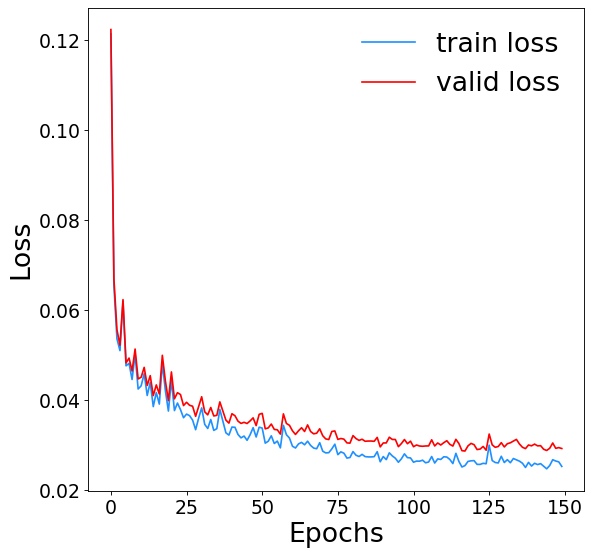

>>> gaussian_correction_model
GNN_LAYERS =  4
EMBEDDING_SIZE =  10
HIDDEN_FEATURES_SIZE =  30
Epoch: 001, Loss: 0.16063, train_loss: 0.08427, valid_loss: 0.08845
Epoch: 011, Loss: 0.04619, train_loss: 0.04375, valid_loss: 0.04539
Epoch: 021, Loss: 0.03856, train_loss: 0.03785, valid_loss: 0.04009
Epoch: 031, Loss: 0.03529, train_loss: 0.03513, valid_loss: 0.03706
Epoch: 041, Loss: 0.03427, train_loss: 0.03325, valid_loss: 0.03528
Epoch: 051, Loss: 0.03272, train_loss: 0.03595, valid_loss: 0.03802
Epoch: 061, Loss: 0.03154, train_loss: 0.03281, valid_loss: 0.03493
Epoch: 071, Loss: 0.03115, train_loss: 0.03023, valid_loss: 0.03270
Epoch: 081, Loss: 0.02997, train_loss: 0.02978, valid_loss: 0.03243
Epoch: 091, Loss: 0.02892, train_loss: 0.02808, valid_loss: 0.03084
Epoch: 101, Loss: 0.02844, train_loss: 0.02823, valid_loss: 0.03147
Epoch: 111, Loss: 0.02839, train_loss: 0.03007, valid_loss: 0.03404
Epoch: 121, Loss: 0.02693, train_loss: 0.02747, valid_loss: 0.03129
Epoch: 131, Loss: 0.02

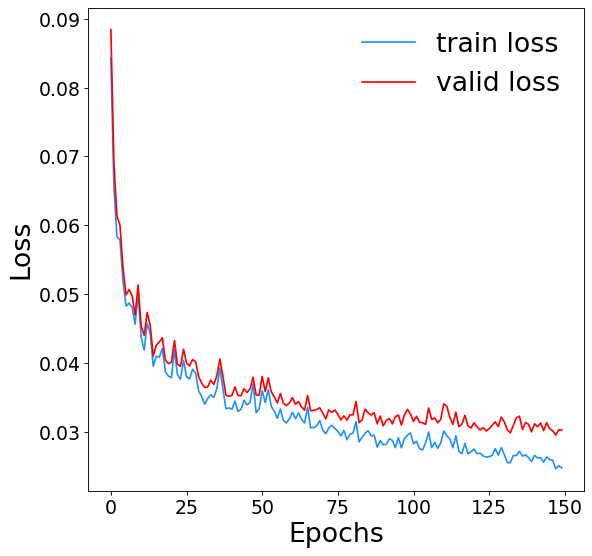

In [5]:
# systems = ['vanilla', 'soft_con', 'mean_cor', 'gaussian_cor']
systems = [ 'mean_cor', 'gaussian_cor']
models = []
iteration=0
for system in systems:
    model = charge_prediction_system(train_loader, valid_loader,NUM_NODE_FEATURES,EMBEDDING_SIZE,GNN_LAYERS,HIDDEN_FEATURES_SIZE,train_data_size, valid_data_size, MAX_EPOCHS, iteration, system, crit)
    models.append(model)


In [10]:
# saving and loading of models for testing purposes 
# torch.save(models, './deployment/models.pt')
# torch.save(models, 'models.pt')
# models = torch.load('./models.pt')

Total MOFs: 454


Total Nodes: 67715
Method 			 MAD 	 avg_abs_sum_charge 	 max_charge_sum 	 min_charge_sum
---------------------------------------------------------------------------------------
mean_cor 		 0.026544 	 0.000066 	 0.000630 		 -0.000475


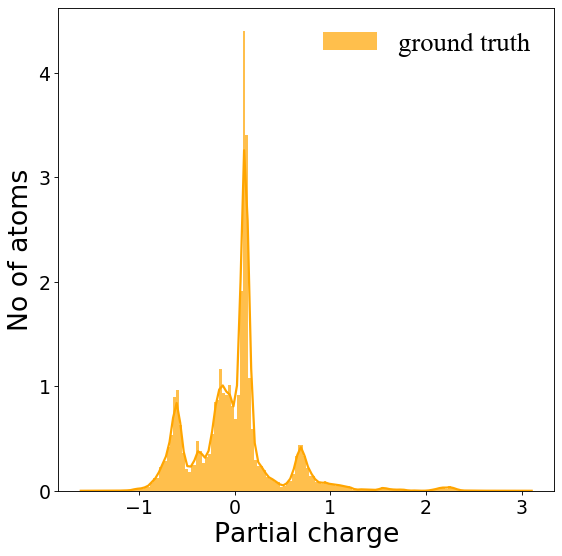

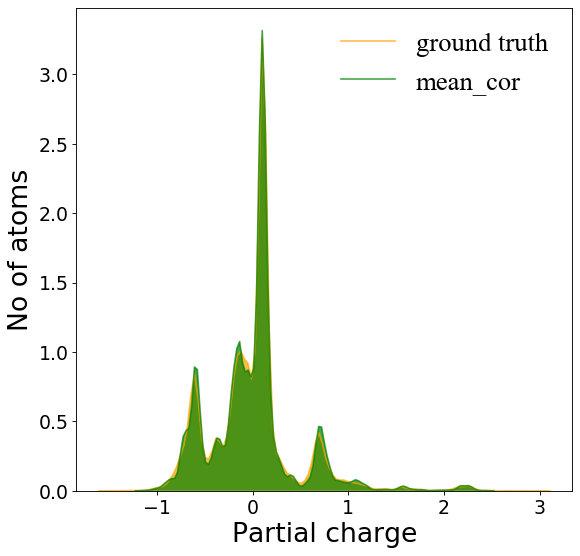

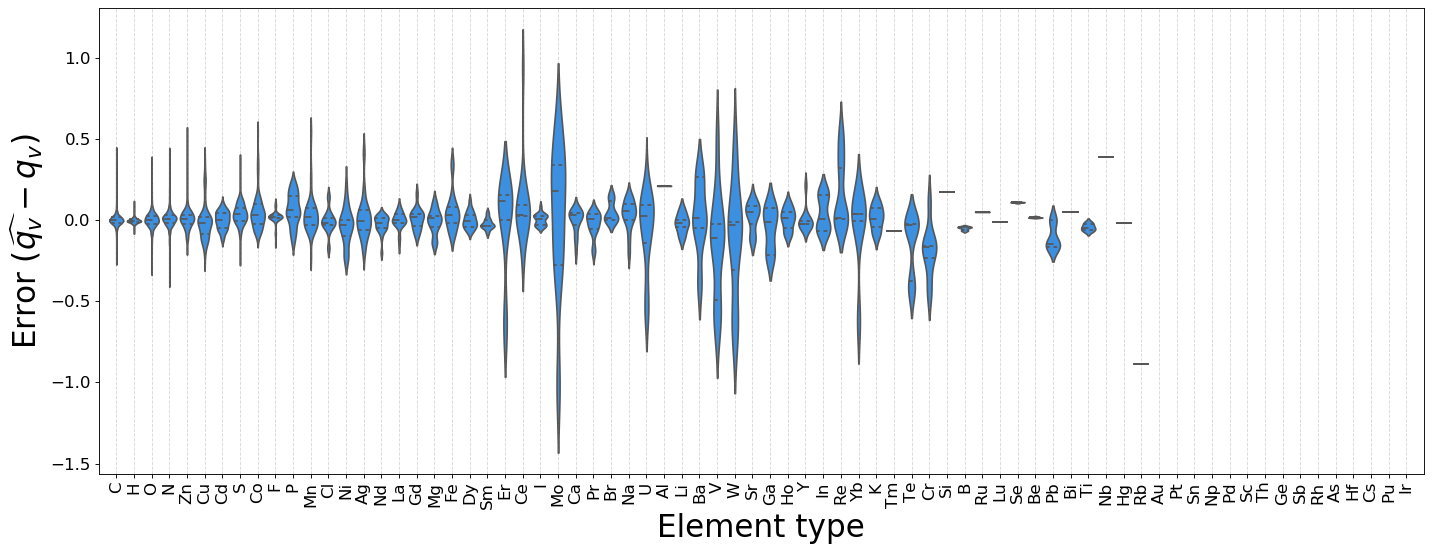

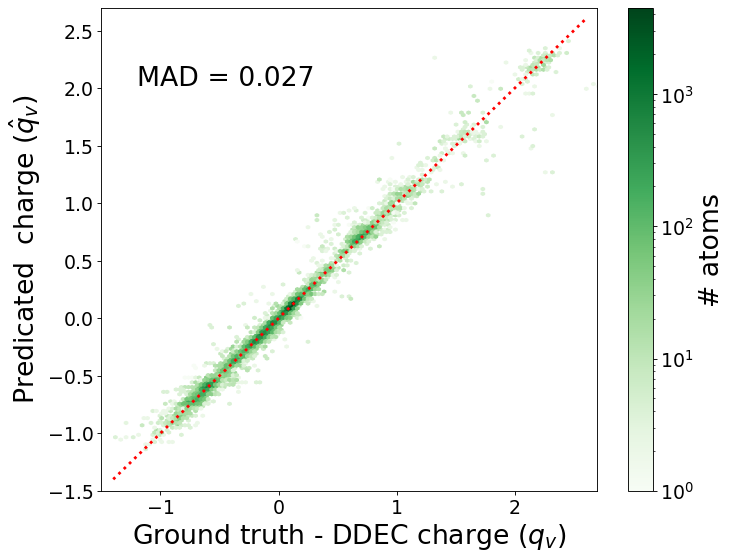

Method 			 MAD 	 avg_abs_sum_charge 	 max_charge_sum 	 min_charge_sum
---------------------------------------------------------------------------------------
gaussian_cor 		 0.026597 	 0.000011 	 0.000133 		 -0.000088


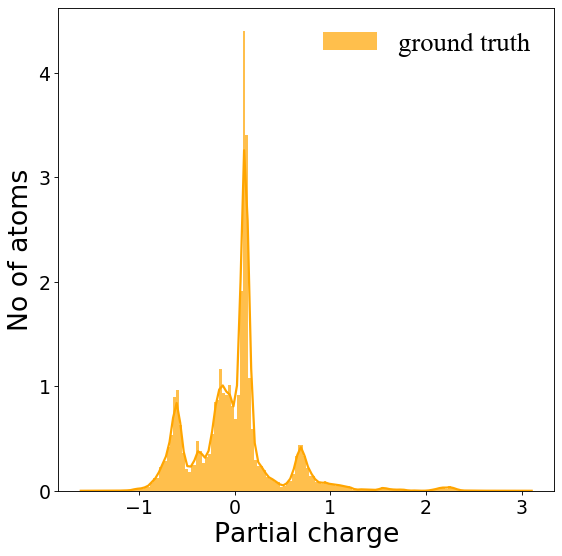

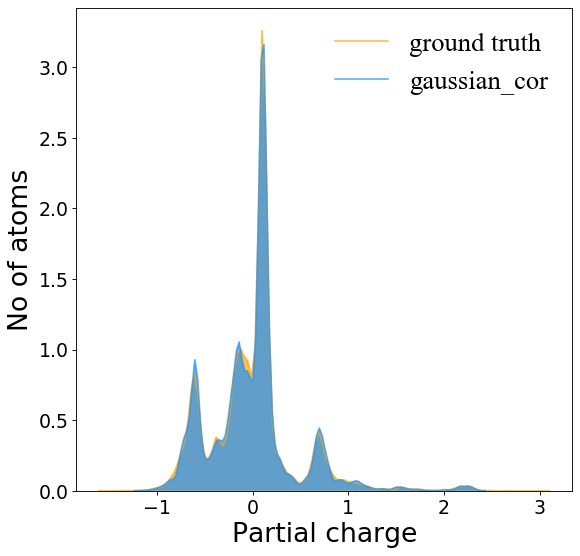

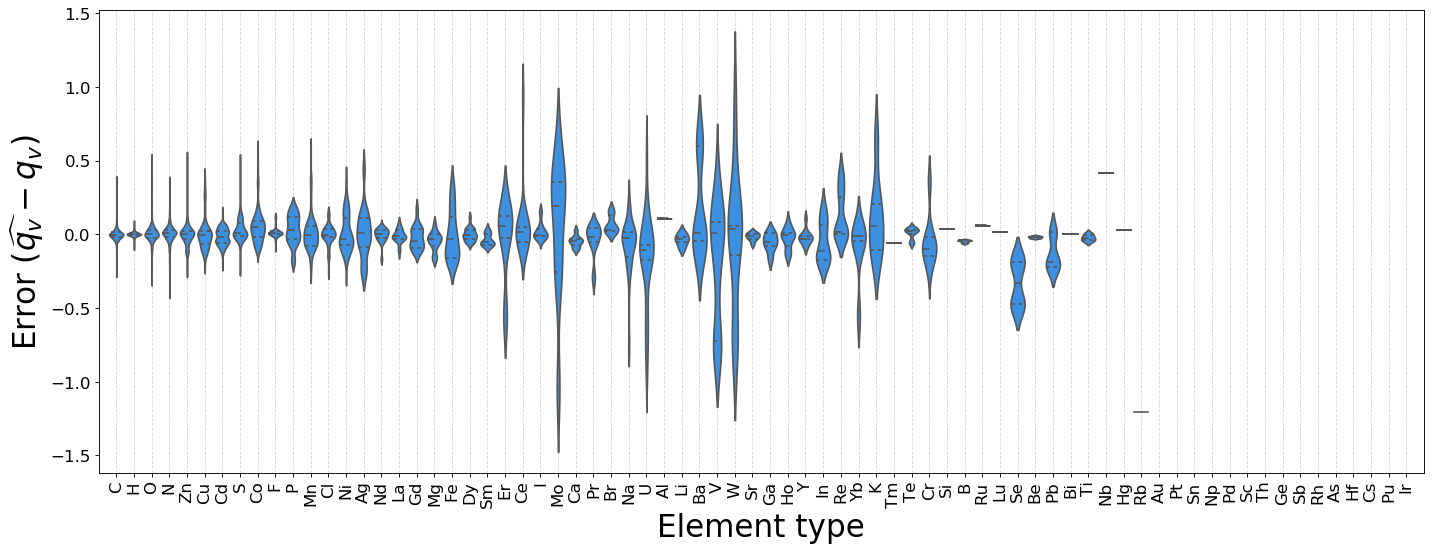

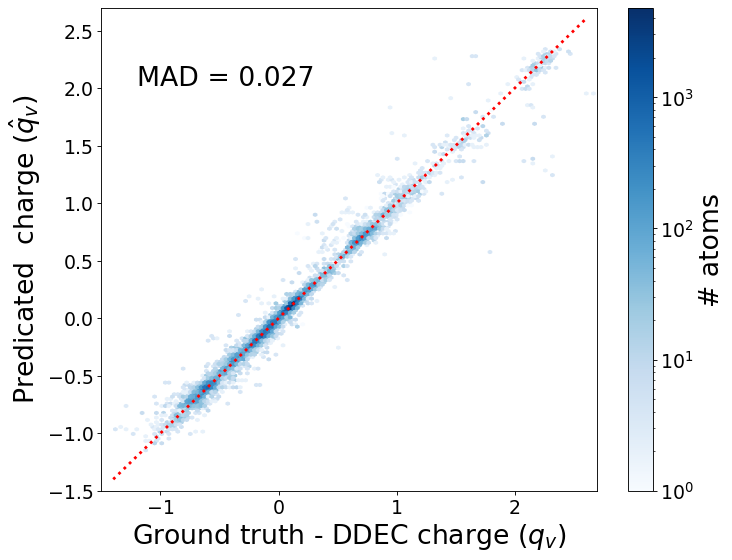

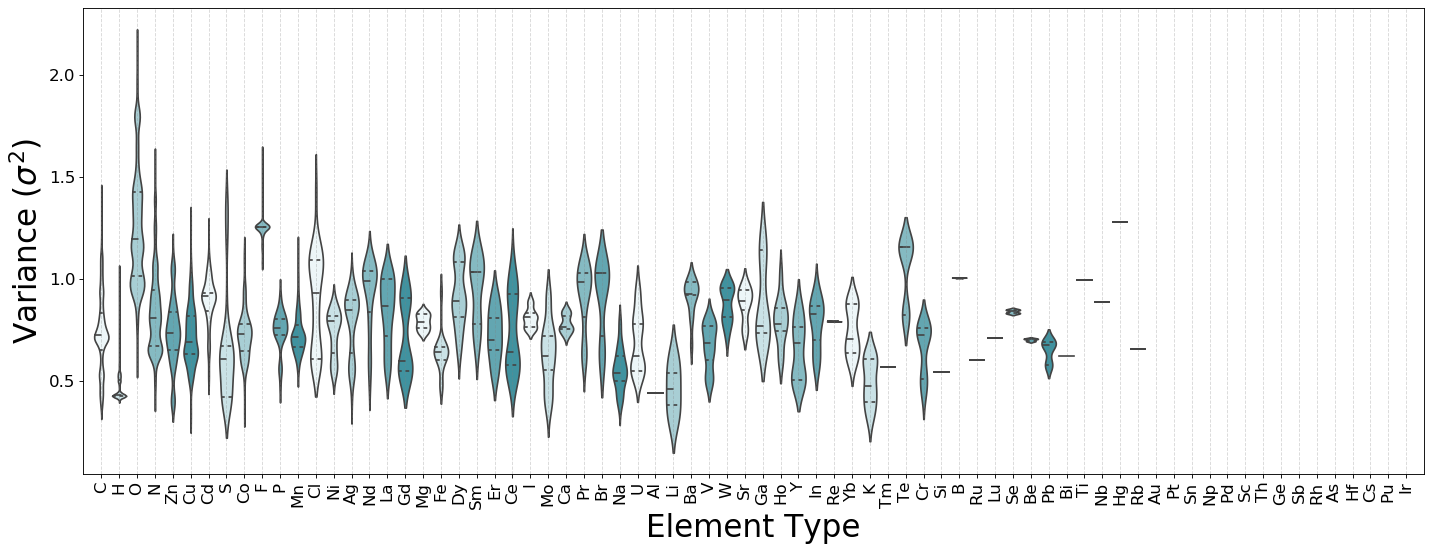

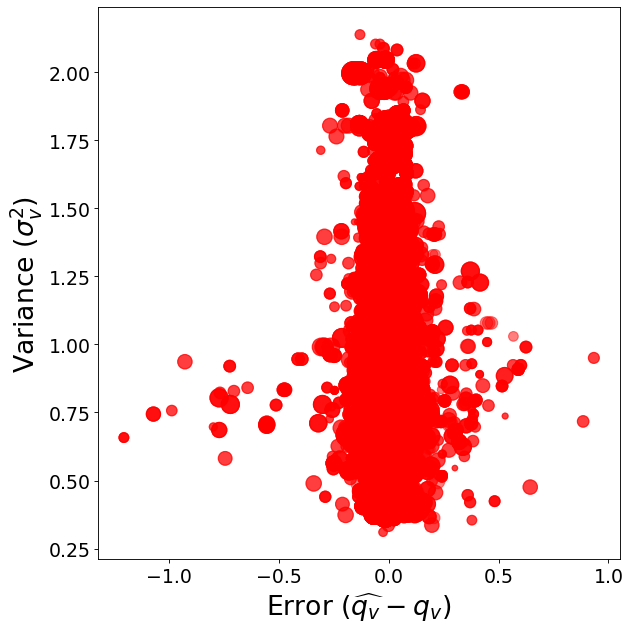

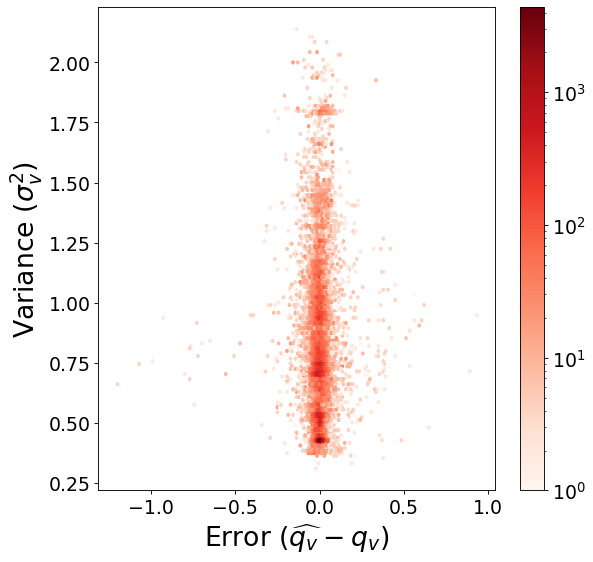

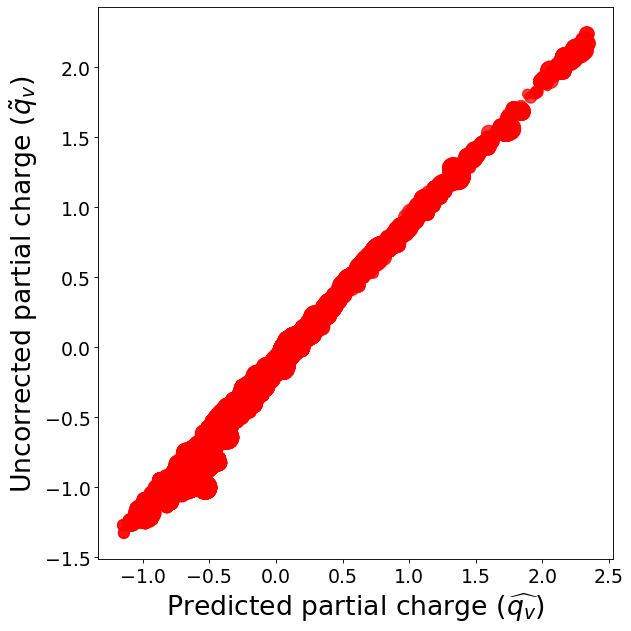

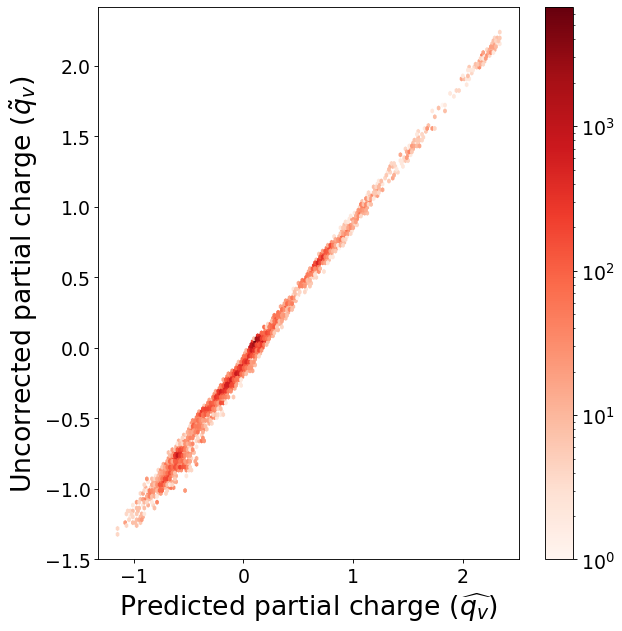

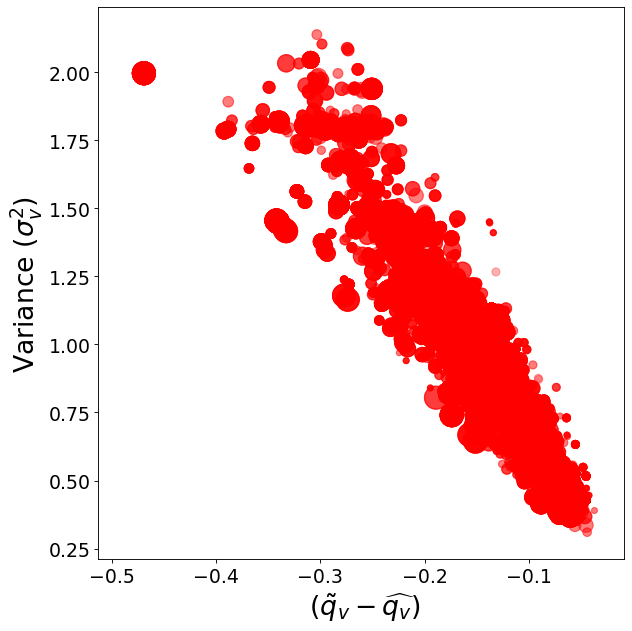

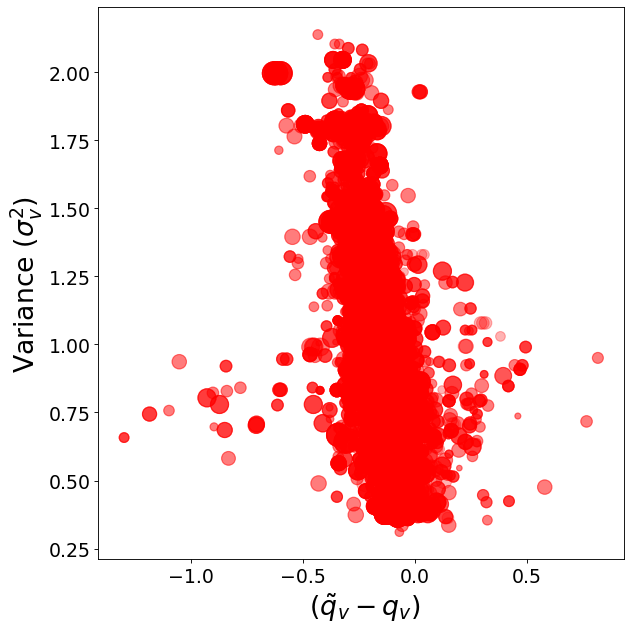

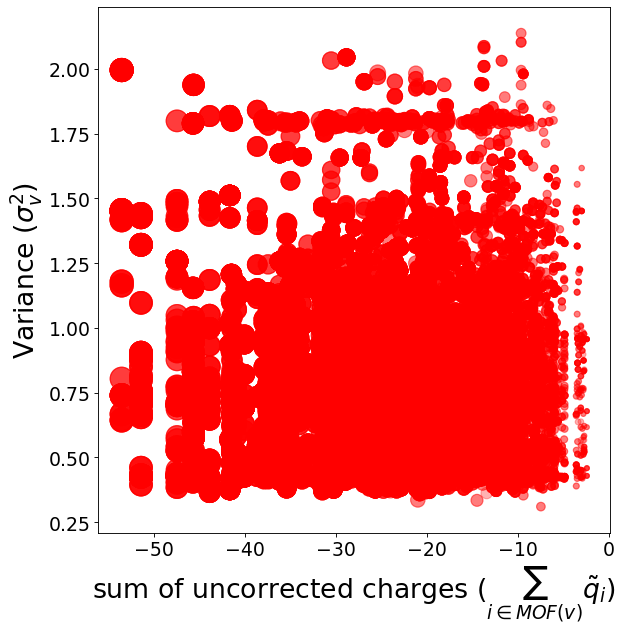

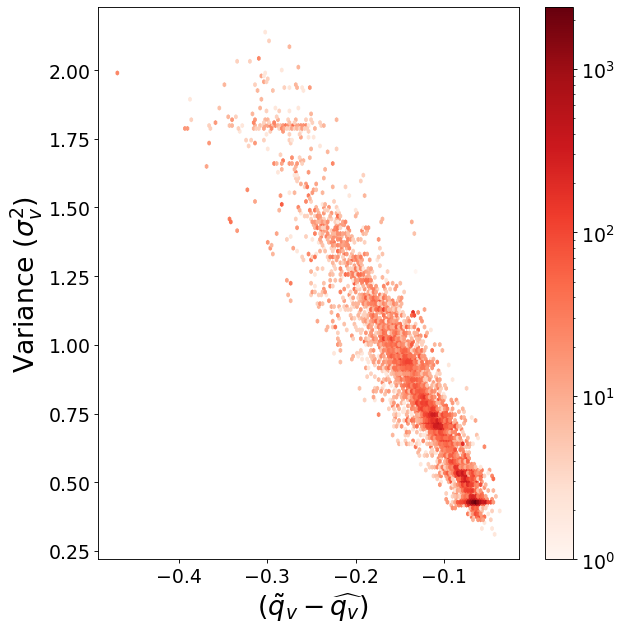

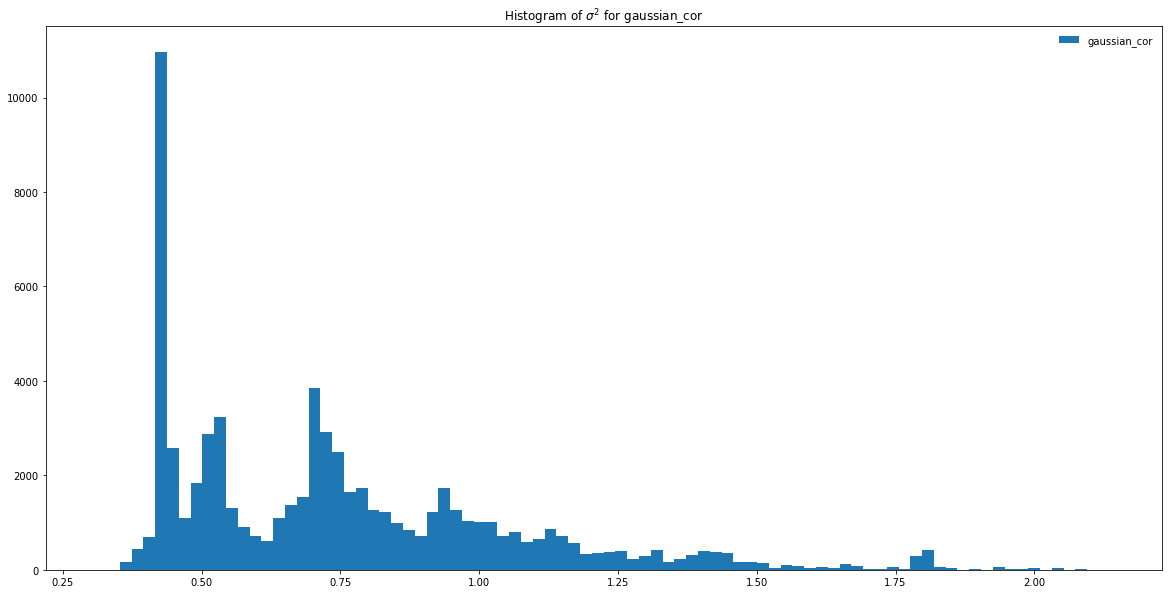

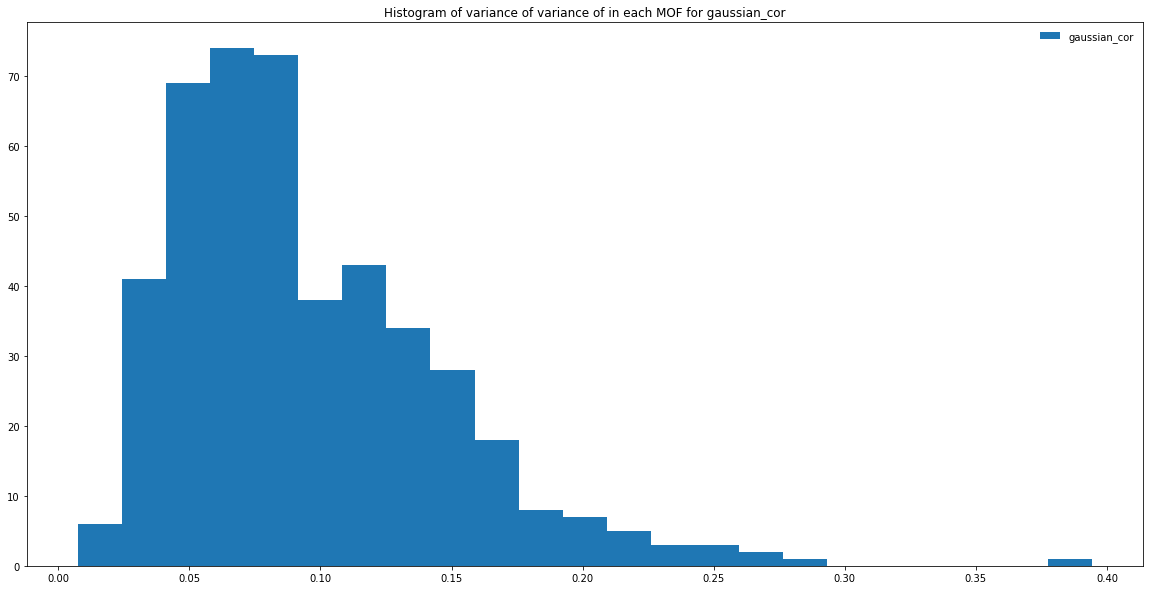

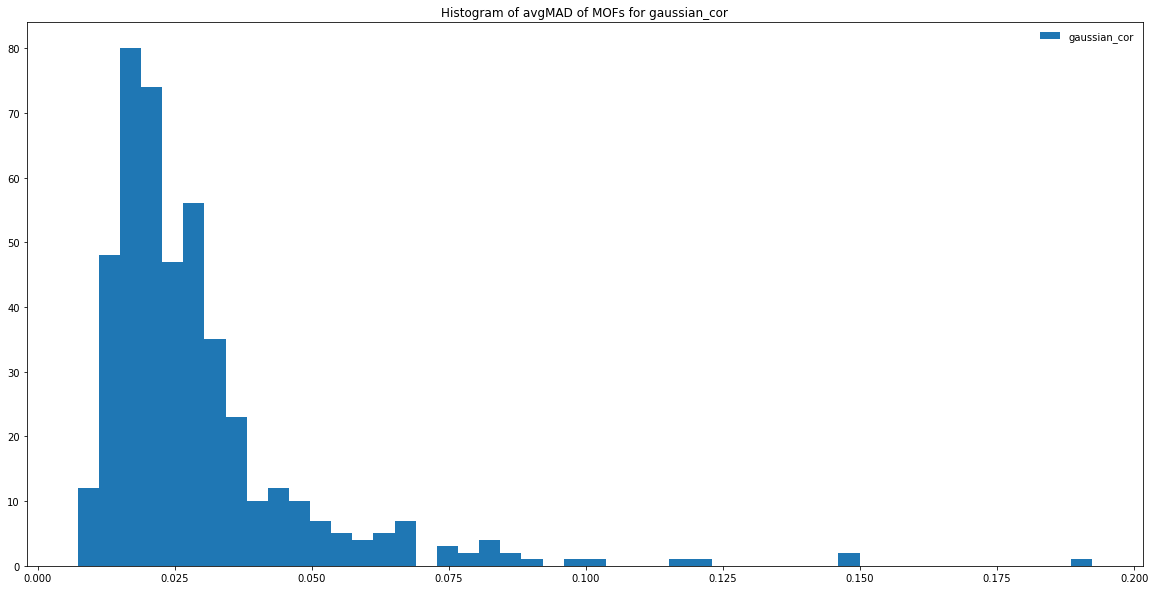

<Figure size 720x2160 with 0 Axes>

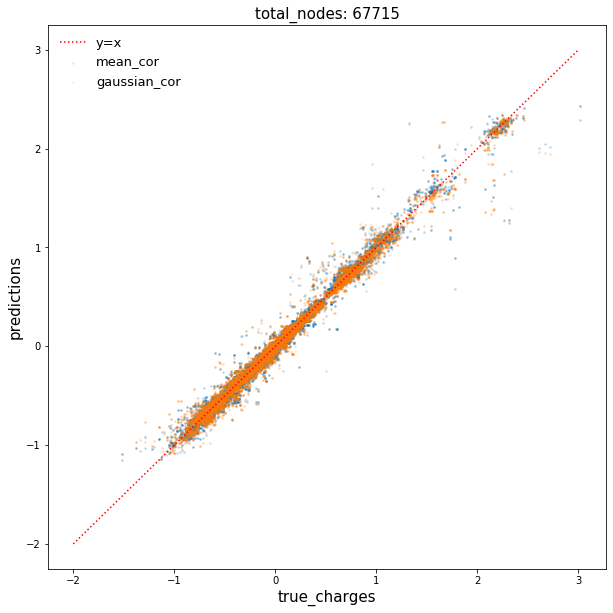

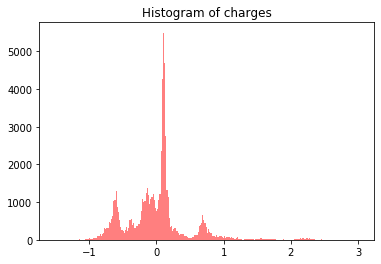

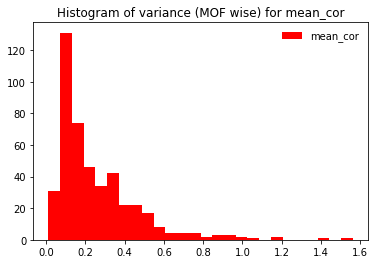

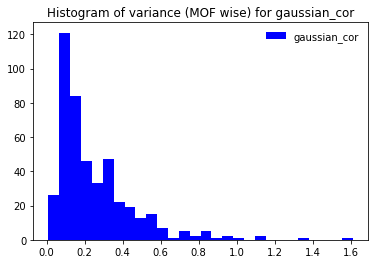

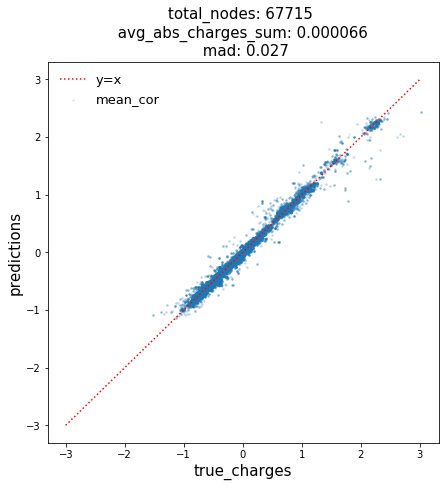

IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:

# for testing and results

# dataa = train_dataset
dataa = test_dataset
# dataa = valid_dataset
# dataa = data_list
loader = DataLoader(dataa, batch_size=len(dataa))



loss_all = np.zeros( (len(systems), MAX_ITERATIONS) )
charge_sum_all = np.zeros( (len(systems), MAX_ITERATIONS) )
mad_all = np.zeros( (len(systems), MAX_ITERATIONS) )
print("Total MOFs: {}".format(len(dataa) ))
# module for evaluating
print()
print()

predictions = []
embeddings = []
variance_charge= []
sigma_all = []
with torch.no_grad():
    for data in loader:
        data = data.to(device)
        label = data.y.to(device)
        features = data.x.to(device)
        print("Total Nodes: {}".format(len(label)))
        for index, system in enumerate(systems):        
            model = models[index]
            model.eval()
            pred, embedding, sigmas, uncorrected_mu = model(data)
            # hard coded predictions for comparison 
#             pred[:] = 0
            predictions.append(pred)
            embeddings.append(embedding)
            
            loss = crit(pred, label)
            sum_charge =   ts.scatter_add(pred, data.batch, dim=0)
            mean_tt =  ts.scatter_mean(pred, data.batch, dim=0)
#             variance = E[X^2] - (E[X])^2
            variance_charge.append(  ts.scatter_mean(torch.mul(pred,pred), data.batch, dim=0) - torch.mul(mean_tt,mean_tt) )
            print("Method \t\t\t MAD \t avg_abs_sum_charge \t max_charge_sum \t min_charge_sum")
            print("---------------------------------------------------------------------------------------")
            print(system, "\t\t {:.6f} \t {:.6f} \t {:.6f} \t\t {:.6f}".format(loss.item(),np.average(np.absolute(sum_charge.cpu().numpy()) ),np.max(sum_charge.cpu().numpy()), np.min(sum_charge.cpu().numpy())))
            
            charge_sum_all[index,iteration] = np.average(np.absolute(sum_charge.cpu().numpy()) )
            
            error_all = pred.cpu().numpy() - label.cpu().numpy()                
            mad_all[index,iteration] = np.mean(np.absolute(error_all))
            loss_all[index,iteration] = loss.item() 
            
                    
            #-------------------------------------------------------------------            
            plt.figure(figsize=(8,8), dpi= 80)
            sns.distplot(label.cpu().numpy(), color="orange", hist_kws={'alpha':.7}, kde_kws={'linewidth':2},label='ground truth', bins=150 )

            plt.xlabel('Partial charge', fontsize=fontsize_label_legend, **hfont)
            plt.ylabel('No of atoms',fontsize=fontsize_label_legend, **hfont)
            plt.legend(frameon=False, prop={"family":"Times New Roman", 'size': fontsize_label_legend})
            plt.tick_params(axis='both', which='major', labelsize=17)
            plt.savefig('results/graphs/ground_distplot.png', format='png', dpi=300, bbox_inches="tight")
            plt.show()

            #-------------------------------------------------------------------            
            #histogram of prediction and ground truth
            
            colors = ['green', 'dodgerblue', 'deeppink' ]
            plt.figure(figsize=(8,8), dpi= 80)

            sns.kdeplot(label.cpu().numpy(), shade=True, color="orange", label="ground truth", alpha=.7)
            sns.kdeplot(pred.cpu().numpy(), shade=True, color=colors[index], label=system, alpha=.7)
            plt.xlabel('Partial charge', fontsize=fontsize_label_legend, **hfont)
            plt.ylabel('No of atoms', fontsize=fontsize_label_legend, **hfont)
            plt.legend(frameon=False, prop={"family":"Times New Roman", 'size': fontsize_label_legend})
            plt.tick_params(axis='both', which='major', labelsize=17)
            plt.savefig('results/graphs/ground_{}_histogram.png'.format(system), format='png', dpi=300, bbox_inches="tight")

            plt.show()
            
            #-------------------------------------------------------------------            
#             # saving mean sigmas of elements
#             element_types_labels = np.zeros(len(label))

#             for element_index in range(elements_number):
#                     indices = (features[:, element_index ] == 1)
#                     element_types_labels[indices.cpu().numpy()] = element_index
#             sigmas_mean = ts.scatter_mean(pred, torch.from_numpy(element_types_labels), dim=0)
#             print("sigmas_mean.size(): ", sigmas_mean.size())

            #
            #-------------------------------------------------------------------            
            # dis'tn of errors based on elements, violin plot
            
            fig = plt.figure(figsize=(18, 7), dpi= 80) # Create matplotlib figure
            ax = fig.add_subplot(111) # Create matplotlib axes
            element_types_labels = np.zeros(len(label))

            for element_index in range(elements_number):
                    indices = (features[:, indices_sorted_elements[element_index] ] == 1)
                    element_types_labels[indices.cpu().numpy()] = element_index

#             sns.violinplot(x=element_types_labels, y=error_all, scale='width', inner='quartile',palette="GnBu_d")
#             sns.violinplot(x=element_types_labels, y=error_all, scale='width', inner='quartile',palette=sns.light_palette((210, 90, 60), input="husl"))
            sns.violinplot(x=element_types_labels, y=error_all, scale='width', inner='quartile',color = 'dodgerblue', alpha=0.7)
            # Decoration
            plt.xlabel('Element type', fontsize = 28, **hfont)
            plt.ylabel('Error ' + r'$(\widehat{q_v} - q_v)$', fontsize = 28, **hfont)
            plt.xticks(np.arange(elements_number), element_types2, rotation='vertical', size=15, **hfont)
#             plt.ylim((-3,4))
            plt.xlim((-1,74))
            plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
            plt.tick_params(axis='both', which='major', labelsize=15)
            plt.tight_layout()
            plt.savefig('results/graphs/error_violinplot_{}.png'.format(system), format='png', dpi=300, bbox_inches="tight")
            plt.show()
            
            #-------------------------------------------------------------------            
            # hexbin for different systems          

            cmaps = ['Greens','Blues','Reds']
            fig = plt.figure(figsize=(10,8), dpi= 80)
            hb = plt.hexbin(label.cpu().numpy(), pred.cpu().numpy(), gridsize=150,  cmap=cmaps[index],mincnt=1, bins = 'log')
            cb = fig.colorbar(hb)
            cb.ax.tick_params(labelsize=17) 
            cb.set_label('# atoms', size = fontsize_label_legend)
            x = np.linspace(-1.4,2.6,100)
            y = x
            plt.plot(x, y, ':r', label='y=x', linewidth = 2.5)
            plt.xlabel('Ground truth - DDEC charge '+ r'$(q_v)$', fontsize=fontsize_label_legend, **hfont)
            plt.ylabel('Predicated  charge '+ r'$(\hat{q}_v)$', fontsize=fontsize_label_legend, **hfont)
#             plt.legend(frameon=False, prop={"family":"Times New Roman", 'size': fontsize_label_legend})
            plt.tick_params(axis='both', which='major', labelsize=17)
            plt.ylim((-1.5,2.7))
            plt.xlim((-1.5,2.7))
            plt.text(x=-1.2, y= 2.2, s="MAD = {:.3f}".format(loss.item()), fontdict=dict(fontsize=fontsize_label_legend), color='black', va='top', ha='left')
#             plt.legend('MAD', frameon = False )
            plt.savefig('results/graphs/hexbin_'+system+'.png', format='png', dpi=300, bbox_inches="tight")
            plt.show()
            #------------------------------------------------------------------- 
            
            if system == 'gaussian_cor':
                
                
                #-------------------------------------------------------------------            
                
                
                # dis'tn of sigmas based on elements, violin plot


                fig = plt.figure(figsize=(18, 7), dpi= 80) # Create matplotlib figure
                ax = fig.add_subplot(111) # Create matplotlib axes
                element_types_labels = np.zeros(len(label))
                # sorting based on elements number
                for element_index in range(elements_number):
                        indices = (features[:, indices_sorted_elements[element_index] ] == 1)
                        element_types_labels[indices.cpu().numpy()] = element_index

                sns.violinplot(x=element_types_labels, y=sigmas.cpu().numpy(), scale='width', inner='quartile',palette=sns.light_palette((210, 90, 60), input="husl"))
                # Decoration
                plt.xlabel('Element Type', fontsize = 28, **hfont)
                plt.ylabel('Variance ' + r'$(\sigma^2)$', fontsize = 28, **hfont)
                plt.xticks(np.arange(elements_number), element_types2, rotation='vertical', size=15, **hfont)
    #             plt.ylim((-3,4))
                plt.xlim((-1,74))
                plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
                plt.tick_params(axis='both', which='major', labelsize=15)
                plt.tight_layout()
                plt.savefig('results/graphs/variance_violinplot_{}.png'.format(system), format='png', dpi=300, bbox_inches="tight")
                plt.show()

                plt.show()
                
                #-------------------------------------------------------------------           
                
                # getting abso sum of predicted charge on all MOFs
                abs_sum_charge_uncor = copy.deepcopy(pred)
                
                sum_charge_uncor =   ts.scatter_add(uncorrected_mu, data.batch, dim=0)
                for t in range(len(sum_charge)):
#                     abs_sum_charge[data.batch == t] = sum_charge[t].item()
                    abs_sum_charge_uncor[data.batch == t] = sum_charge_uncor[t]
                    
            
                
                #-------------------------------------------------------------------           
                #scatter plot of variance vs error
#                 error_all
#                 sigmas.cpu().numpy()
                plt.figure(figsize=(8,8), dpi= 80)
                plt.scatter(error_all, sigmas.cpu().numpy(), s = 8*np.abs(abs_sum_charge_uncor.cpu().numpy()) ,color = 'red', alpha=0.5)
                
                plt.xlabel('Error ' + r'$(\widehat{q_v} - q_v)$' , fontsize=fontsize_label_legend, **hfont)
                plt.ylabel('Variance ' + r'$(\sigma^2_v)$', fontsize=fontsize_label_legend, **hfont)
#                 plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
                plt.tick_params(axis='both', which='major', labelsize=17)
                plt.tight_layout()
                plt.savefig('results/graphs/variance_error_scatterplot_{}.png'.format(system), format='png', dpi=300, bbox_inches="tight")
                plt.show()
                
                # hexbins

                fig = plt.figure(figsize=(8,8), dpi= 80)
                hb = plt.hexbin(error_all, sigmas.cpu().numpy(), gridsize=150,  cmap='Reds',mincnt=1, bins = 'log')
                cb = fig.colorbar(hb)
                cb.ax.tick_params(labelsize=17) 
#                 cb.set_label('Gaussian Correction')
                
                plt.xlabel('Error ' + r'$(\widehat{q_v} - q_v)$' , fontsize=fontsize_label_legend, **hfont)
                plt.ylabel('Variance ' + r'$(\sigma^2_v)$', fontsize=fontsize_label_legend, **hfont)
    #             plt.legend(frameon=False, prop={"family":"Times New Roman", 'size': fontsize_label_legend})
                plt.tick_params(axis='both', which='major', labelsize=17)
                plt.savefig('results/graphs/variance_error_hexbin_{}.png'.format(system), format='png', dpi=300, bbox_inches="tight")
                plt.show()
                #-------------------------------------------------------------------         

                #-------------------------------------------------------------------           
                #scatter plot of q vs mu
#                 pred
#                 uncorrected_mu
                plt.figure(figsize=(8,8), dpi= 80)
                plt.scatter(pred.cpu().numpy(), uncorrected_mu.cpu().numpy(), s = 8*np.abs(abs_sum_charge_uncor.cpu().numpy()) , color = 'red', alpha=0.5)
                
                plt.xlabel('Predicted partial charge ' + r'$(\widehat{q_v} )$' , fontsize=fontsize_label_legend, **hfont)
                plt.ylabel('Uncorrected partial charge ' + r'$(\tilde{q}_v)$', fontsize=fontsize_label_legend, **hfont)
#                 plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
                plt.tick_params(axis='both', which='major', labelsize=17)
                plt.tight_layout()
                plt.savefig('results/graphs/q_mu_scatterplot_{}.png'.format(system), format='png', dpi=300, bbox_inches="tight")
                plt.show()
                
                # hexbins

                fig = plt.figure(figsize=(8,8), dpi= 80)
                hb = plt.hexbin(pred.cpu().numpy(),uncorrected_mu.cpu().numpy(), gridsize=150,  cmap='Reds',mincnt=1, bins = 'log')
                cb = fig.colorbar(hb)
                cb.ax.tick_params(labelsize=17) 
#                 cb.set_label('Gaussian Correction')
                
                plt.xlabel('Predicted partial charge ' + r'$(\widehat{q_v} )$' , fontsize=fontsize_label_legend, **hfont)
                plt.ylabel('Uncorrected partial charge ' + r'$(\tilde{q}_v)$', fontsize=fontsize_label_legend, **hfont)
#                 plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
                plt.tick_params(axis='both', which='major', labelsize=17)
                plt.tight_layout()
                plt.savefig('results/graphs/q_mu_hexbin_{}.png'.format(system), format='png', dpi=300, bbox_inches="tight")
                plt.show()
                #-------------------------------------------------------------------    
                
                #-------------------------------------------------------------------           
                #scatter plot of variance vs mu-q
#                 pred
#                 uncorrected_mu


                
                plt.figure(figsize=(8,8), dpi= 80)
                plt.scatter(uncorrected_mu.cpu().numpy() - pred.cpu().numpy(), sigmas.cpu().numpy(), s = 8*np.abs(abs_sum_charge_uncor.cpu().numpy()) ,color = 'red', alpha=0.3)
                
                plt.xlabel(' ' + r'$(\tilde{q}_v - \widehat{q_v} )$' , fontsize=fontsize_label_legend, **hfont)
                plt.ylabel('Variance ' + r'$(\sigma^2_v)$', fontsize=fontsize_label_legend, **hfont)
#                 plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
                plt.tick_params(axis='both', which='major', labelsize=17)
                plt.tight_layout()
                plt.savefig('results/graphs/variance_mu_q_scatterplot_{}.png'.format(system), format='png', dpi=300, bbox_inches="tight")
                plt.show()
                
                plt.figure(figsize=(8,8), dpi= 80)
                plt.scatter(uncorrected_mu.cpu().numpy() - label.cpu().numpy(), sigmas.cpu().numpy(), s = 8*np.abs(abs_sum_charge_uncor.cpu().numpy()) ,color = 'red', alpha=0.3)
                
                plt.xlabel(' ' + r'$(\tilde{q}_v - {q_v} )$' , fontsize=fontsize_label_legend, **hfont)
                plt.ylabel('Variance ' + r'$(\sigma^2_v)$', fontsize=fontsize_label_legend, **hfont)
#                 plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
                plt.tick_params(axis='both', which='major', labelsize=17)
                plt.tight_layout()
                plt.savefig('results/graphs/variance_mu_label_scatterplot_{}.png'.format(system), format='png', dpi=300, bbox_inches="tight")
                plt.show()
                
                plt.figure(figsize=(8,8), dpi= 80)
                plt.scatter((abs_sum_charge_uncor.cpu().numpy()), sigmas.cpu().numpy(), s = 8*np.abs(abs_sum_charge_uncor.cpu().numpy()) ,color = 'red', alpha=0.3)
                
                plt.xlabel('sum of uncorrected charges ' + r'$( \sum_{i \in MOF(v)} \tilde{q}_i  )$' , fontsize=fontsize_label_legend, **hfont)
                plt.ylabel('Variance ' + r'$(\sigma^2_v)$', fontsize=fontsize_label_legend, **hfont)
#                 plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
                plt.tick_params(axis='both', which='major', labelsize=17)
                plt.tight_layout()
                plt.savefig('results/graphs/variance_sum_scatterplot_{}.png'.format(system), format='png', dpi=300, bbox_inches="tight")
                plt.show()
                
                
                # hexbins

                fig = plt.figure(figsize=(8,8), dpi= 80)
                hb = plt.hexbin(uncorrected_mu.cpu().numpy() - pred.cpu().numpy(), sigmas.cpu().numpy(), gridsize=150,  cmap='Reds',mincnt=1, bins = 'log')
                
                cb = fig.colorbar(hb)
                cb.ax.tick_params(labelsize=17) 
#                 cb.set_label('Gaussian Correction')
                
                plt.xlabel(' ' + r'$(\tilde{q}_v - \widehat{q_v} )$' , fontsize=fontsize_label_legend, **hfont)
                plt.ylabel('Variance ' + r'$(\sigma^2_v)$', fontsize=fontsize_label_legend, **hfont)
#                 plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
                plt.tick_params(axis='both', which='major', labelsize=17)
                plt.tight_layout()
                plt.savefig('results/graphs/variance_mu_q_hexbin_{}.png'.format(system), format='png', dpi=300, bbox_inches="tight")
                plt.show()
                
                
                
                #-------------------------------------------------------------------    
                
                
                #sigmas  variance of all nodes. need variance of variance in each MOF
                mean_tt =  ts.scatter_mean(sigmas, data.batch, dim=0)
                variance_of_variance =  ts.scatter_mean(torch.mul(sigmas,sigmas), data.batch, dim=0) - torch.mul(mean_tt,mean_tt)
                
                plt.figure(figsize = (20,10))
#                 plt.figure
                plt.hist(sigmas.cpu().numpy(), bins='auto', label=system  )
                plt.title("Histogram of $\sigma ^2$ for {}".format(system))
                plt.legend(frameon = False)
                plt.show()
                
                plt.figure(figsize = (20,10))
#                 plt.figure
                plt.hist(variance_of_variance.cpu().numpy(), bins='auto', label=system  )
                plt.title("Histogram of variance of variance of in each MOF for {}".format(system))
                plt.legend(frameon = False)
                plt.show()
                # maximum variance 
                
#                 print("MOF with maximum variance of variance: {}".format(np.argmax (variance_of_variance.cpu().numpy()) ))
#                 print(np.argsort(variance_of_variance.cpu().numpy())[::-1])
#                 crystal_names = np.load('crystals_name.npy')
#                 print("MOF with maximum variance of variance")
#                 print("MOF name \t\t variance_of_variance \t\t avgMAD ")
#                 print("-------------------------------------------------------")
#                 print("{} \t\t {}".format(crystal_names[ np.argsort(variance_of_variance.cpu().numpy())[::-1] ], variance_of_variance[ np.argsort(variance_of_variance.cpu().numpy())[::-1] ]) )
                # average MAD of each MOF
                error_mof = pred - label
                error_mof =  ts.scatter_mean(torch.abs(error_mof), data.batch, dim=0) 
                # plotting histogram of avgMAD of MOFs
                plt.figure(figsize = (20,10))
#                 plt.figure
                plt.hist(error_mof.cpu().numpy(), bins='auto', label=system  )
                plt.title("Histogram of avgMAD of MOFs for {}".format(system))
                plt.legend(frameon = False)
                plt.show()

#                 for cc in     np.argsort(variance_of_variance.cpu().numpy())[::-1] :
#                     print(crystal_names[cc], '\t\t', variance_of_variance[cc], error_mof[cc])
            
            
        axi = plt.figure(figsize=(10,30))                
        plt.figure(figsize=(10,10))
        for index, system in enumerate(systems):
            plt.scatter(label.cpu().numpy(), predictions[index].cpu().numpy(),s=10, alpha=0.1, marker='.', label=system)
        plt.xlabel('true_charges', size= 15)
        plt.ylabel('predictions', size= 15)
        plt.title("total_nodes: {}".format(len(label)), size= 15)
        x = np.linspace(-2,3,100)
        y = x
        plt.plot(x, y, ':r', label='y=x')
        plt.legend(frameon=False, prop={'size': 13})
#             plt.savefig('results/r2/' + str(i)+'.png')
#             i+=1
        plt.show()
    
        plt.figure()
        plt.hist( label.cpu().numpy(), bins='auto', color='r', histtype='bar', alpha=0.5, label=system)
        plt.title("Histogram of charges")
        plt.show()
        #----------------------------------------------------------------------

        
# #----------------------------------------------------------------------------------------------
#         #HEXBIN
# # hexbin for all systems             

#         cmaps = ['Reds','Greens','Blues']
#         fig = plt.figure(figsize=(8,8))
#         for index, system in enumerate(systems):
            
#             hb = plt.hexbin(label.cpu().numpy(), predictions[index].cpu().numpy(), gridsize=150,  cmap=cmaps.pop(),mincnt=1, bins = 'log')
#             cb = fig.colorbar(hb)
#             cb.set_label(system, size = 22)
#         x = np.linspace(-3,3,100)
#         y = x
        
#         plt.xlabel('true_charges', size= 15)
#         plt.ylabel('predictions', size= 15)
#         plt.plot(x, y, ':r', label='y=x')
#         plt.title("For all systems")
# #             plt.legend(frameon=False, prop={'size': 13})
          
#         plt.show()
    
#=----------------------------------------------------------------------------------        
#     # histogram of variance
#         plt.figure(figsize = (20,10))
# #         plt.hist([variance_charge[1].cpu().numpy(),variance_charge[2].cpu().numpy()], bins='auto', label=[systems[1], systems[2]], color = ['b', 'g'] )
#         plt.title("Histogram of variance (MOF wise) for two systems")
#         plt.legend(frameon = False)
#         plt.show()
                  
        colors = ['red', 'blue', 'green']
#         plt.figure()
        for index, system in enumerate(systems):
            plt.figure()
            plt.hist( variance_charge[index].cpu().numpy(), bins='auto', color=colors[index], histtype='bar', alpha=1.0, label=system)
            plt.title("Histogram of variance (MOF wise) for {}".format(system))
            plt.legend(frameon = False)
            plt.show()
#=----------------------------------------------------------------------------------            
        for index, system in enumerate(systems):
            plt.figure(figsize=(7,7))

            plt.scatter(label.cpu().numpy(), predictions[index].cpu().numpy(),s=10, alpha=0.1, marker='.', label=system)
            

            plt.xlabel('true_charges', size= 15)
            plt.ylabel('predictions', size= 15)
            plt.title("total_nodes: {} \n avg_abs_charges_sum: {:.6f} \n mad: {:.3f}".format(len(label), charge_sum_all[index,iteration], loss_all[index,iteration]), size= 15)
            x = np.linspace(-3,3,100)
            y = x
            plt.plot(x, y, ':r', label='y=x')
            plt.legend(frameon=False, prop={'size': 13})
            plt.show()

            # for different element types 
            elements_number = len(features[0])
            mean_error_all = np.zeros(elements_number)
            min_error_all = np.zeros(elements_number)
            max_error_all = np.zeros(elements_number)
            mad_element_all = np.zeros(elements_number)
            error_all = []
            mean_element_all = np.zeros(elements_number)
            min_element_all = np.zeros(elements_number)
            max_element_all = np.zeros(elements_number)
            
            total_instances_all = np.zeros(elements_number)
            embedding_all = []
            for element_index in range(elements_number):
                indices = (features[:,element_index]==1)
                total_instances_all[element_index] =  np.count_nonzero(label[indices].cpu().numpy())
                error = label[indices].cpu().numpy() - predictions[index][indices].cpu().numpy()
#                 print(features[indices].cpu().numpy())
#                 print(embedding[indices].cpu().numpy()[0])
                embedding_all.append(embeddings[index][indices].cpu().numpy()[0])
            
#                 for tt in embeddings[index][indices]:
#                     embedding_all.append(tt.cpu().numpy())
#                     embedding_labels.append()
#                 print(error.shape)
                if(len(error)>0):
                    mean_error_all[element_index] = np.mean(error)
                    error_all.append(error)
                    min_error_all[element_index] = min(error)
                    max_error_all[element_index] = max(error)
                    mad_element_all[element_index] = np.mean(np.absolute(error))
                label_element = label[indices].cpu().numpy()
                if(len(label_element)>0):
                    mean_element_all[element_index] = np.mean(label_element)
                    min_element_all[element_index] = min(label_element)
                    max_element_all[element_index] = max(label_element)

    # #             trend line 
    #             for index, system in enumerate(systems):
    #                 plt.scatter(label[indices].cpu().numpy(), predictions[index][indices].cpu().numpy(),s=200, alpha=0.2, marker='.', label=system)
    #             plt.xlabel('true_charges', size= 15)
    #             plt.ylabel('predictions', size= 15)
    #             plt.title("Item Type: 1 \n total_nodes: {}".format(len(label[indices]) ), size= 15)
    #             x = np.linspace(-3,3,100)
    #             y = x
    #             plt.plot(x, y, ':r', label='y=x')
    #             plt.legend(frameon=False, prop={'size': 13})
    #             #             plt.savefig('results/r2/' + str(i)+'.png')
    #             #             i+=1
    #             plt.show()
            # box plot of distribution of y_i - y_i^
#             plt.figure(figsize=(30,10))
#==================================================
#saving embeddings 
            if (FLAG_SAVE_EMBEDDING):
                np.save("results/embedding/embedding_{}".format(system), embedding_all)
            
                # ARNI please put your 
#==================================================
            # visualize embedding of elements
            
            #train original features 
            import pandas as pd

#             X =train_input.reshape(train_input.size()[0],-1).cpu().numpy()
            X = np.asarray(embedding_all)
#             for ss in X:
#                 print(ss)
            y = np.asarray(element_types)
            print("TNSE X.shape, y.shape: ", X.shape, y.shape)

            feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
            df = pd.DataFrame(X,columns=feat_cols)
            df['y'] = y
            df['label'] = df['y'].apply(lambda i: str(i))
            # X, y = None, None
            print('Size of the dataframe: {}'.format(df.shape))
            # For reproducability of the results
            np.random.seed(42)
            rndperm = np.random.permutation(df.shape[0])
            N = X.shape[0]
            df_subset = df.loc[rndperm[:N],:].copy()
            data_subset = df_subset[feat_cols].values
            import time
            from sklearn.manifold import TSNE

            time_start = time.time()
            perplexity = 2
            tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
            tsne_results = tsne.fit_transform(data_subset)
            print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
            %matplotlib inline
            import seaborn as sns
            df_subset['tsne-2d-one'] = tsne_results[:,0]
            df_subset['tsne-2d-two'] = tsne_results[:,1]
            
            plt.figure(figsize=(16,10))
            p1=sns.scatterplot(
                x="tsne-2d-one", y="tsne-2d-two",
                hue="y",
                palette=sns.color_palette("hls", 74),
                data=df_subset,
                legend="full",
#                 legend = False,
                 s=90,
                alpha=1.0
            )
            
            p1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),ncol=2)
            for line in range(0,df_subset.shape[0]):
                 p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
                 y[line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
            plt.title("TSNE embedding for {} \n perplexity = {}".format(system, perplexity))
            plt.savefig('results/embedding/tsne_embedding_' + system+ '.png',bbox_inches="tight")
            plt.show()
            
#===========================================================
            ## PCA
            from sklearn.preprocessing import StandardScaler
            X = np.asarray(embedding_all)
            y = np.asarray(element_types)
            X = StandardScaler().fit_transform(X)
            print("PCA X.shape, y.shape: ", X.shape, y.shape)
            df = pd.DataFrame(data=y, columns=['targets'])
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            principalComponents = pca.fit_transform(X)
            principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
            finalDf = pd.concat([principalDf, df['targets']], axis = 1)
#             fig = plt.figure(figsize = (8,8))
#             ax = fig.add_subplot(1,1,1) 
#             ax.set_xlabel('Principal Component 1', fontsize = 15)
#             ax.set_ylabel('Principal Component 2', fontsize = 15)
#             ax.set_title('2 component PCA', fontsize = 20)
# #             targets = y
            
            plt.figure(figsize=(16,10))
            
            p1=sns.scatterplot(
                x="principal component 1", y="principal component 2",
                hue="targets",
                palette=sns.color_palette("hls", 74),
                data=finalDf,
                legend="full",
#                 legend = False,
                 s=90,
                alpha=1.0
            )
            p1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),ncol=2)
            for line in range(0,df_subset.shape[0]):
                 p1.text(finalDf['principal component 1'][line]+0.01, finalDf['principal component 2'][line], 
                 y[line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
            plt.title("PCA embedding for {}".format(system))
            plt.savefig('results/embedding/pca_embedding_' + system+ '.png',bbox_inches="tight")
            plt.show()
# #             colors = ['r', 'g', 'b']
#             for target, color in zip(targets,colors):
#                 indicesToKeep = finalDf['target'] == target
#                 ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#                            , finalDf.loc[indicesToKeep, 'principal component 2']
# #                            , c = color
#                            , s = 50)
#             ax.legend(targets)
#             ax.grid()
#             plt.show()
            
#===========================================================    
            # UMAP
            X = np.asarray(embedding_all)
            y = np.asarray(element_types)
#             X = StandardScaler().fit_transform(X)
            print("UMAP X.shape, y.shape: ", X.shape, y.shape)
#           df = pd.DataFrame(data=y, columns=['targets'])
            feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
            df = pd.DataFrame(X,columns=feat_cols)
            df['y'] = y

#             sns.pairplot(df, hue='y');
#             plt.show()
        
            
            import umap
#             reducer = umap.UMAP(random_state=42)
            n_neighbors = 10
            min_dist = 0
            reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
            
#             reducer.fit(X)
#             UMAP(a=1.576943460405378, alpha=1.0, angular_rp_forest=False, b=0.8950608781227859, bandwidth=1.0, gamma=1.0, init='spectral', 
#                  local_connectivity=1.0, metric='euclidean', metric_kwds={}, min_dist=0.1, n_components=2, n_epochs=None, n_neighbors=15, 
#                  negative_sample_rate=5, random_state=42, set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical', target_metric_kwds={}, 
#                  transform_queue_size=4.0, transform_seed=42, verbose=False)
#             embedding = reducer.transform(X)
#             # Verify that the result of calling transform is
#             # idenitical to accessing the embedding_ attribute
#             assert(np.all(embedding == reducer.embedding_))
#             embedding.shape
            
            
            embedding = reducer.fit_transform(X)
            print(embedding.shape)
            
            principalDf = pd.DataFrame(data = embedding, columns = ['principal component 1', 'principal component 2'])
            finalDf = pd.concat([principalDf, df['y']], axis = 1)
            
            plt.figure(figsize=(16,10))
            
            p1=sns.scatterplot(
                x="principal component 1", y="principal component 2",
                hue="y",
                palette=sns.color_palette("hls", 74),
                data=finalDf,
                legend="full",
#                 legend = False,
                 s=90,
                alpha=1.0
            )
            p1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),ncol=2)
            for line in range(0,df_subset.shape[0]):
                 p1.text(finalDf['principal component 1'][line]+0.01, finalDf['principal component 2'][line], 
                 y[line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
            plt.title("UMAP embedding for {} \n n_neigbors = {}, min_dist = {}".format(system,n_neighbors, min_dist ))
            plt.savefig('results/embedding/umap_embedding_' + system+ '.png',bbox_inches="tight")
            plt.show()
            
 